In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Import libraries
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.applications import EfficientNetB0
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.optimizers import  Adam
from sklearn.metrics import accuracy_score
from tensorflow import keras
from PIL import Image
from skimage import transform

In [3]:
#List of file paths for train, test and validation data

train_dir = Path('../fruit_veg_detection/data/Training')
train_lst = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path('../fruit_veg_detection/data/Test')
test_lst = list(test_dir.glob(r'**/*.jpg'))

val_dir = Path('../fruit_veg_detection/data/Validation')
val_lst = list(test_dir.glob(r'**/*.jpg'))

In [4]:
def df_images(lst_filepaths):
    """ 
    from the list above create a dataframe containing a coulmn of the path and labels of the pictures
    """

    labels = [str(lst_filepaths[i]).split("/")[-2] for i in range(len(lst_filepaths))]

    lst_filepaths = pd.Series(lst_filepaths, name='path').astype(str)
    labels = pd.Series(labels, name='label')

    df = pd.concat([lst_filepaths, labels], axis=1)

    # Shuffle dataframe in-place and reset index 
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [12]:
def print_info(df):
  print("In this dataframe you have {} labels and {} picture to work with".format(len(df.label.unique()), df.shape[0]))


In [10]:
def display_picture(df):
  df2 = df.copy()
  df2 = df2.drop_duplicates(subset=["label"]).reset_index()

  fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(12, 10),
                        subplot_kw={'xticks': [], 'yticks': []})
  
  for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df2.path[i]))
    ax.set_title(df2.label[i], fontsize = 15)
  plt.tight_layout()
  plt.show()



In [7]:
train_df = df_images(train_lst)
test_df = df_images(test_lst)
val_df = df_images(val_lst)

In [8]:
print(train_df)

                                                   path              label
0     /content/drive/MyDrive/Colab Notebooks/private...        apple_red_3
1     /content/drive/MyDrive/Colab Notebooks/private...             pear_1
2     /content/drive/MyDrive/Colab Notebooks/private...     apple_golden_3
3     /content/drive/MyDrive/Colab Notebooks/private...     apple_golden_3
4     /content/drive/MyDrive/Colab Notebooks/private...        apple_red_2
...                                                 ...                ...
6226  /content/drive/MyDrive/Colab Notebooks/private...  apple_pink_lady_1
6227  /content/drive/MyDrive/Colab Notebooks/private...        apple_red_2
6228  /content/drive/MyDrive/Colab Notebooks/private...     apple_golden_3
6229  /content/drive/MyDrive/Colab Notebooks/private...             pear_1
6230  /content/drive/MyDrive/Colab Notebooks/private...            apple_6

[6231 rows x 2 columns]


In [13]:
print_info(train_df)

In this dataframe you have 24 labels and 6231 picture to work with


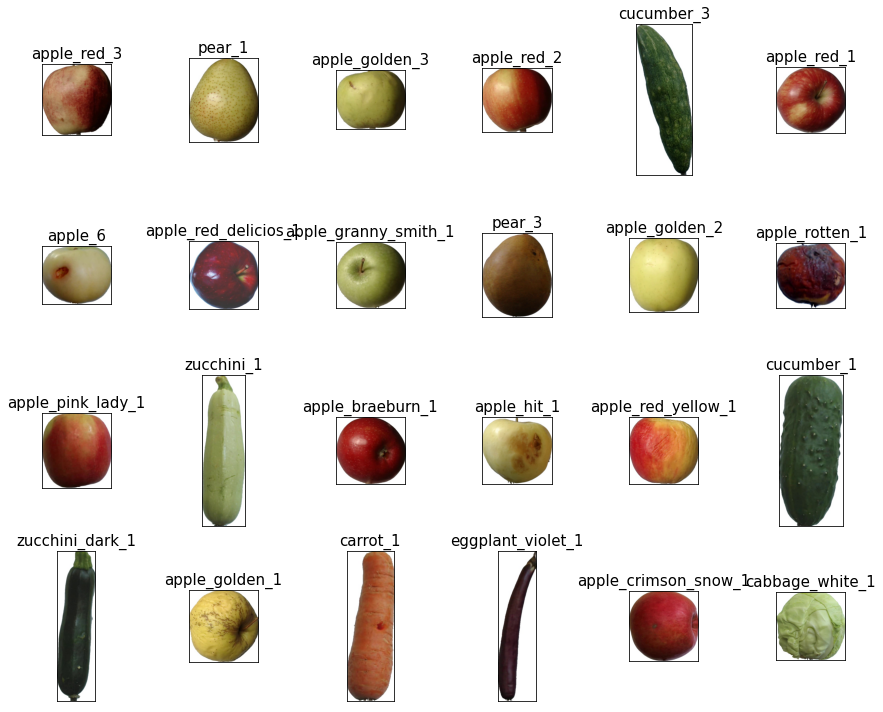

In [14]:
display_picture(train_df)

Generate batches from the dataframes above
source: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [15]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42, #42 the answer to everything :D 
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 6231 validated image filenames belonging to 24 classes.
Found 3110 validated image filenames belonging to 24 classes.
Found 3110 validated image filenames belonging to 24 classes.


Helpful functions

In [16]:
#Create plots of loss and accuracy on the training and validation sets.

def plot_loss_acc(history, epochs):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss=history.history['loss']
  val_loss=history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

In [24]:
def acc_score_display(model):
  # Predict the label of the test_images
  pred = model.predict(test_images)
  pred = np.argmax(pred,axis=1)

  # Map the label
  labels = (train_images.class_indices)
  labels = dict((v,k) for k,v in labels.items())
  pred = [labels[k] for k in pred]

  y_test = [labels[k] for k in test_images.classes]

  acc = accuracy_score(y_test, pred)
  print(f'Accuracy on the test set: {100*acc:.2f}%')

  # Display some pictures of the dataset with their labels and the predictions
  fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                          subplot_kw={'xticks': [], 'yticks': []})

  for i, ax in enumerate(axes.flat):
      ax.imshow(plt.imread(test_df.path.iloc[i]))
      ax.set_title(f"True: {test_df.label.iloc[i]}\nPredicted: {pred[i]}")
  plt.tight_layout()
  plt.show()
  

In [29]:
def load(path):
   np_image = Image.open(path)
   np_image = np.array(np_image).astype('float32')
   np_image = transform.resize(np_image, (224, 224, 3))
   np_image = np.expand_dims(np_image, 0)
   return np_image
  
def single_image_pred(model, path):
  image = load(path)
  predictions = model.predict(image)
  class_names = train_df.label.unique()
  print(
      "This image is most likely a {} with a {:.2f} percent confidence."
      .format(class_names[np.argmax(predictions)], 100 * np.max(predictions))
  )


In [19]:
#path for one image
path = '/content/drive/MyDrive/Colab Notebooks/private projects/fruit_veg_detection/data/test individual image/apple.png'

First model

In [20]:
model1 = Sequential()
model1.add(InputLayer(input_shape=(224, 224, 3)))
# 1st conv block
model1.add(Conv2D(25, (5, 5), activation='relu', strides=(1, 1), padding='same'))
model1.add(MaxPool2D(pool_size=(2, 2), padding='same'))
# 2nd conv block
model1.add(Conv2D(50, (5, 5), activation='relu', strides=(2, 2), padding='same'))
model1.add(MaxPool2D(pool_size=(2, 2), padding='same'))
model1.add(BatchNormalization())
# 3rd conv block
model1.add(Conv2D(70, (3, 3), activation='relu', strides=(2, 2), padding='same'))
model1.add(MaxPool2D(pool_size=(2, 2), padding='valid'))
model1.add(BatchNormalization())
# ANN block
model1.add(Flatten())
model1.add(Dense(units=100, activation='relu'))
model1.add(Dense(units=100, activation='relu'))
model1.add(Dropout(0.25))
# output layer
model1.add(Dense(24, activation='softmax'))
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 25)      1900      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 25)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 50)        31300     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 50)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 50)       200       
 ormalization)                                                   
                                                        

In [21]:
model1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history1 = model1.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )]
)

Epoch 1/5
195/195 [==============================] - 2026s 10s/step - loss: 0.4731 - accuracy: 0.8519 - val_loss: 0.8184 - val_accuracy: 0.7164
Epoch 2/5
195/195 [==============================] - 50s 258ms/step - loss: 0.0872 - accuracy: 0.9729 - val_loss: 1.1923 - val_accuracy: 0.7096
Epoch 3/5
195/195 [==============================] - 50s 257ms/step - loss: 0.0261 - accuracy: 0.9912 - val_loss: 1.5562e-04 - val_accuracy: 1.0000
Epoch 4/5
195/195 [==============================] - 50s 257ms/step - loss: 0.0052 - accuracy: 0.9986 - val_loss: 0.0030 - val_accuracy: 0.9990
Epoch 5/5
195/195 [==============================] - 50s 255ms/step - loss: 0.0248 - accuracy: 0.9925 - val_loss: 0.0077 - val_accuracy: 0.9981


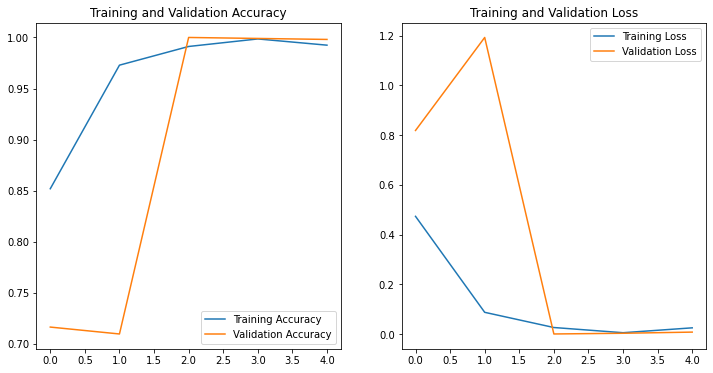

In [22]:
plot_loss_acc(history1, 5)

98/98 [==============================] - 16s 166ms/step
Accuracy on the test set: 100.00%


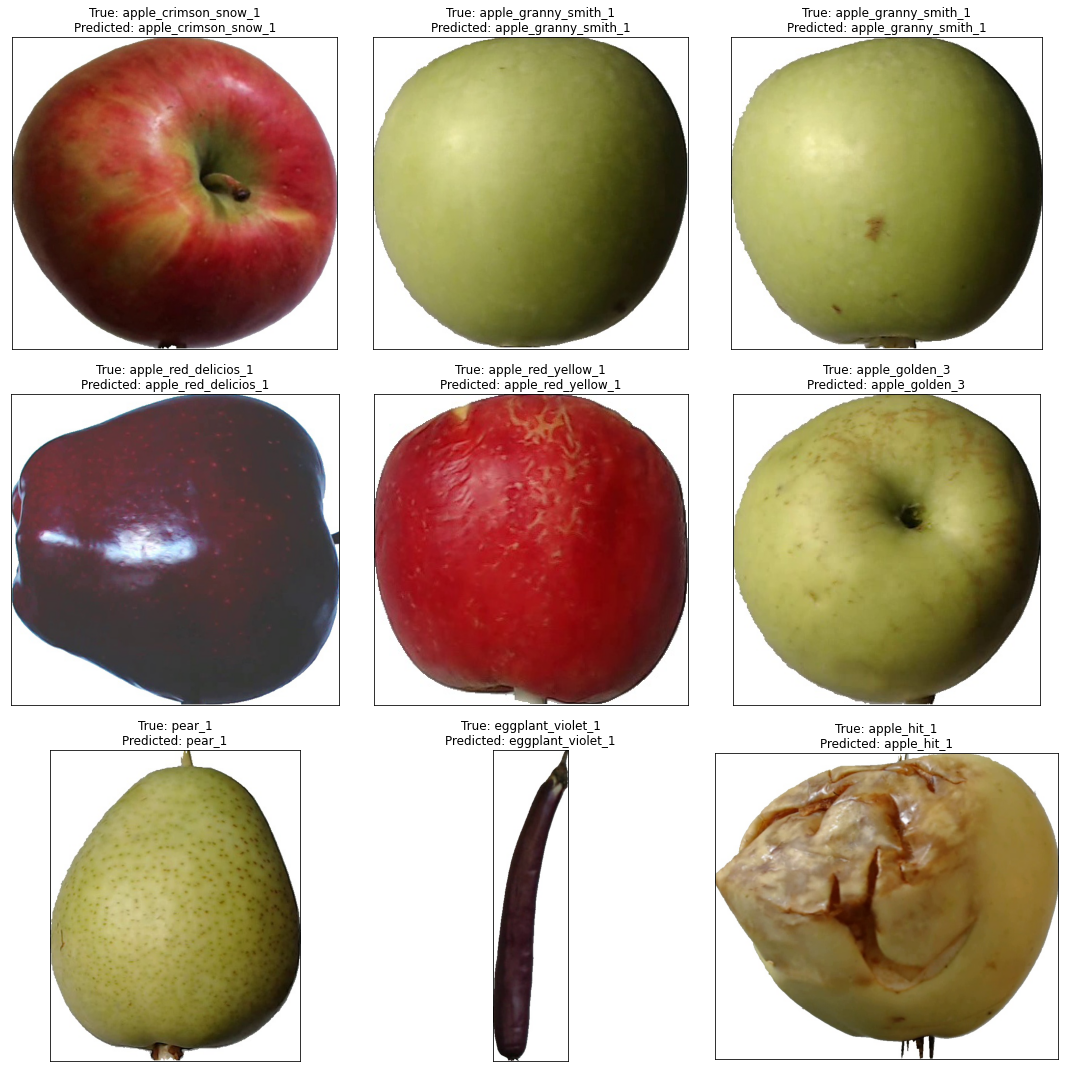

In [27]:
acc_score_display(model1)

In [31]:
single_image_pred(model1, path)

1/1 [==============================] - 0s 20ms/step
This image is most likely a pear_1 with a 100.00 percent confidence.


VGG

In [32]:
vgg = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224, 224, 3),
    classes=24,
    classifier_activation="softmax",
)

modelvgg = Sequential()
modelvgg.add(vgg)
modelvgg.add(layers.Dropout(0.3))
modelvgg.add(layers.Flatten())
modelvgg.add(layers.Dropout(0.5))
modelvgg.add(layers.Dense(24, activation='softmax'))

modelvgg.layers[0].trainable = False

modelvgg.summary()

80134624/80134624 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 512)         0         
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_2 (Dropout)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 24)                602136    
                                                                 
Total params: 20,626,520
Trainable params: 602,136
Non-trainable params: 20,024,384
_____________________________________

In [33]:
adam = Adam(learning_rate = 0.0001)
modelvgg.compile(optimizer=adam,
    loss='categorical_crossentropy',
    metrics=['accuracy'])

historyvgg = modelvgg.fit(train_images, validation_data=val_images,
    batch_size = 32,
    epochs=5,
        callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ])

Epoch 1/5
195/195 [==============================] - 51s 257ms/step - loss: 1.6016 - accuracy: 0.5476 - val_loss: 0.3412 - val_accuracy: 0.9939
Epoch 2/5
195/195 [==============================] - 50s 257ms/step - loss: 0.3588 - accuracy: 0.9275 - val_loss: 0.1116 - val_accuracy: 0.9997
Epoch 3/5
195/195 [==============================] - 49s 252ms/step - loss: 0.1622 - accuracy: 0.9795 - val_loss: 0.0559 - val_accuracy: 1.0000
Epoch 4/5
195/195 [==============================] - 50s 255ms/step - loss: 0.0898 - accuracy: 0.9942 - val_loss: 0.0344 - val_accuracy: 1.0000
Epoch 5/5
195/195 [==============================] - 49s 254ms/step - loss: 0.0594 - accuracy: 0.9970 - val_loss: 0.0234 - val_accuracy: 1.0000


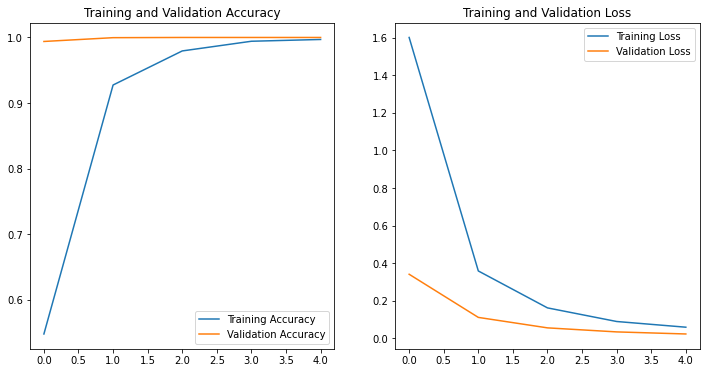

In [34]:
plot_loss_acc(historyvgg, 5)

98/98 [==============================] - 17s 168ms/step
Accuracy on the test set: 100.00%


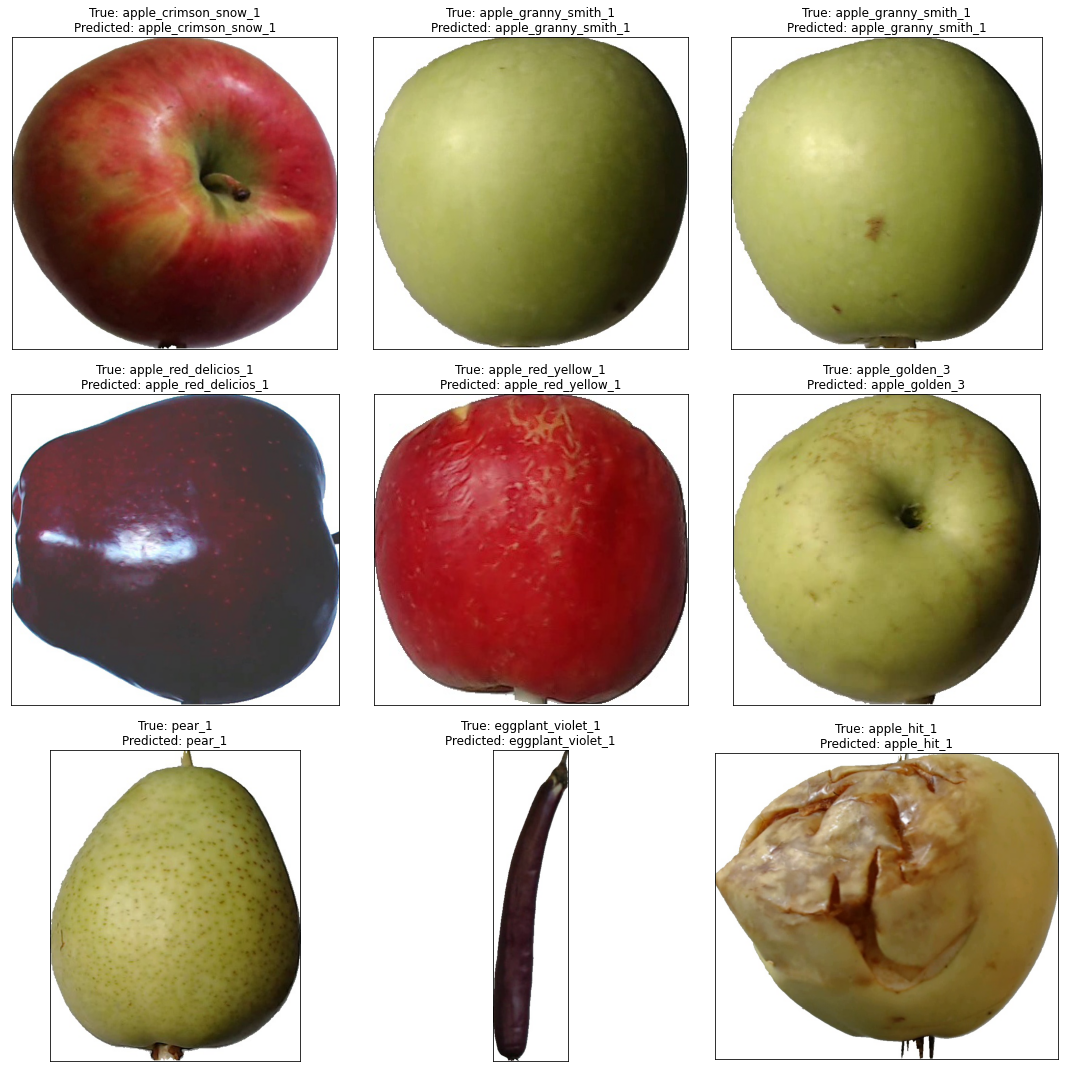

In [35]:
acc_score_display(modelvgg)

In [36]:
single_image_pred(modelvgg, path)

1/1 [==============================] - 0s 313ms/step
This image is most likely a carrot_1 with a 100.00 percent confidence.


MobileNetV2

In [37]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(24, activation='softmax')(x)

modelmnv2 = tf.keras.Model(inputs=inputs, outputs=outputs)

9406464/9406464 [==============================] - 0s 0us/step


In [38]:
modelmnv2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

historymnv2 = modelmnv2.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5
195/195 [==============================] - 53s 258ms/step - loss: 0.3032 - accuracy: 0.9347 - val_loss: 0.0080 - val_accuracy: 1.0000
Epoch 2/5
195/195 [==============================] - 49s 252ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 3/5
195/195 [==============================] - 49s 253ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 4/5
195/195 [==============================] - 49s 251ms/step - loss: 8.6479e-04 - accuracy: 1.0000 - val_loss: 6.6696e-04 - val_accuracy: 1.0000
Epoch 5/5
195/195 [==============================] - 49s 251ms/step - loss: 5.0187e-04 - accuracy: 1.0000 - val_loss: 4.3657e-04 - val_accuracy: 1.0000


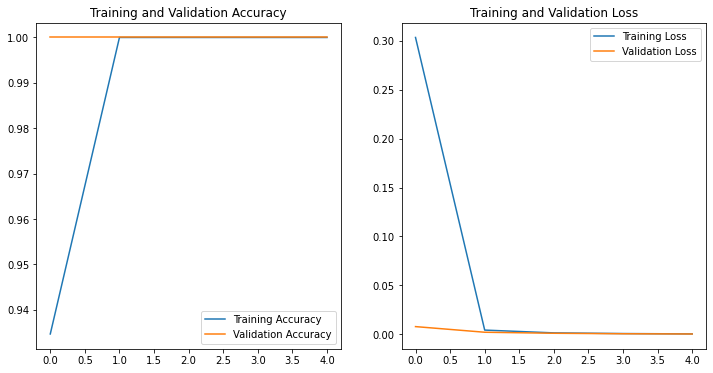

In [39]:
plot_loss_acc(historymnv2, 5)

98/98 [==============================] - 17s 168ms/step
Accuracy on the test set: 100.00%


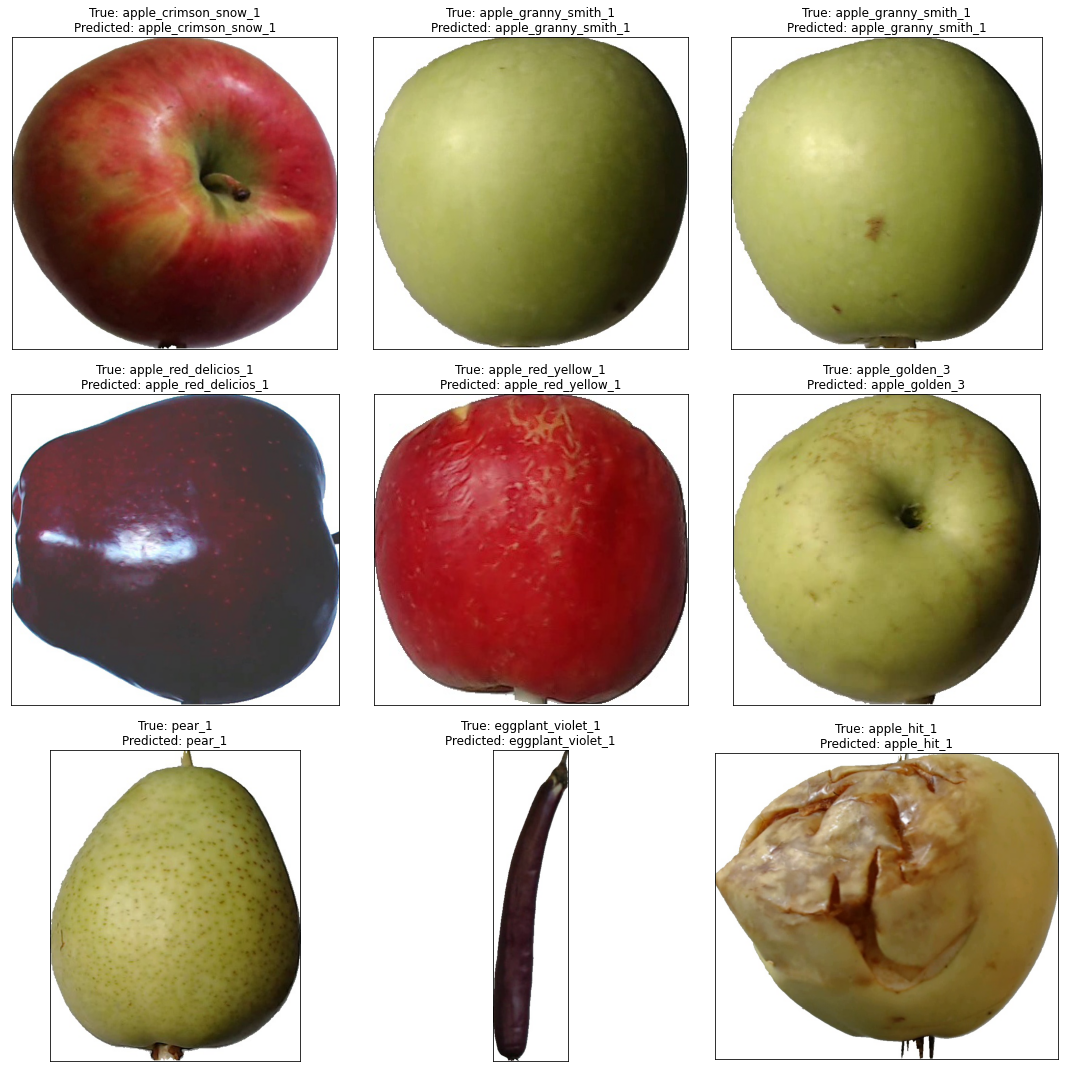

In [40]:
acc_score_display(modelmnv2)

In [41]:
single_image_pred(modelmnv2, path)

1/1 [==============================] - 1s 787ms/step
This image is most likely a carrot_1 with a 45.45 percent confidence.


Save models so they can be easily used in the Streamlit app

In [42]:
model1.save('../fruit_veg_detection/cnn_model')
modelvgg.save('../fruit_veg_detection/vggmodel')
modelmnv2.save('../fruit_veg_detection/mobilenet_model')